In [1]:
import mido 

#inport = mido.open_input('Akai MPD32')

inport = mido.open_input('OCTA-CAPTURE MIDI')


In [2]:
mido.get_input_names()


['Akai MPD32', 'Akai MPD32 Port 3', 'OCTA-CAPTURE CTRL', 'OCTA-CAPTURE MIDI']

In [3]:
inport

<open input 'OCTA-CAPTURE MIDI' (RtMidi/MACOSX_CORE)>

In [4]:
import time

In [5]:
listmsg = []

starttime = time.time()

while True:
    for msg in inport.iter_pending():
        listmsg.append([msg,time.time()-starttime])

KeyboardInterrupt: 

In [6]:
import numpy as np 

focus = []
subjtime=[]

absolute_start =listmsg[0][1]

for curmsg,curt in listmsg:
    if curmsg.control == 20:
        focus.append([curt-absolute_start,curmsg.value])
    elif curmsg.control == 22:
        subjtime.append([curt-absolute_start,curmsg.value])
        
focus = np.stack(focus)
subjtime = np.stack(subjtime)

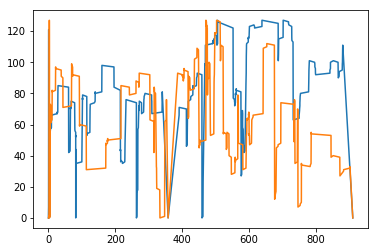

In [7]:
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.plot(focus[:,0],focus[:,1])
plt.plot(subjtime[:,0],subjtime[:,1])

In [8]:
np.savez_compressed('caroleeg_sess2.npz',focus=focus,subjtime=subjtime)

In [59]:
np.

In [177]:
def quantize(vector,res=0.3,endtime=2):
    vectimes = vector[:,0]
    maxtime = max(vectimes)
    
    alltimes = np.arange(0,maxtime-endtime,res)
    
    qvec = []
    ## loop over all time segments between two instants of length "res"
    
    prev_val = vector[0,1]
    
    for i,curtime in enumerate(alltimes[:-2]):
        
        ind = np.argwhere((vectimes>curtime) & (vectimes<alltimes[i+1]))
        
        if len(ind)==0:
            qvec.append([curtime,prev_val])
        else:
            qvec.append([curtime,np.mean(vector[ind,1])])
            prev_val = np.mean(vector[ind,1])
    return np.stack(qvec)
    
focus_q = quantize(focus,res=1)
subt_q = quantize(subjtime,res=1)

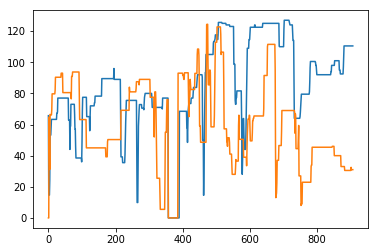

In [178]:
plt.plot(focus_q[:,0],focus_q[:,1])
plt.plot(subt_q[:,0],subt_q[:,1])

ATTENTION - tenir compte d'un délai d'une seconde pour le temps subjectif

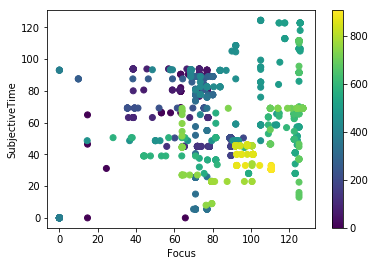

In [179]:
plt.scatter(focus_q[:,1],subt_q[:,1],c=focus_q[:,0])
plt.xlabel('Focus')
plt.ylabel('SubjectiveTime')
plt.colorbar()

In [180]:
from sklearn.metrics.pairwise import cosine_similarity,manhattan_distances,paired_manhattan_distances

X = np.stack([focus_q[30:370,1],subt_q[30:370,1]]).T

S_cos = cosine_similarity(X)

S = manhattan_distances(X)

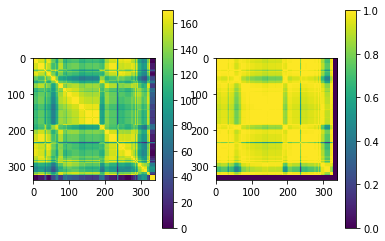

In [181]:
plt.subplot(1,2,1)
plt.imshow(np.max(S)-S)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(S_cos)
plt.colorbar()

In [183]:
from sklearn.cluster import SpectralClustering

Spectral clustering
--

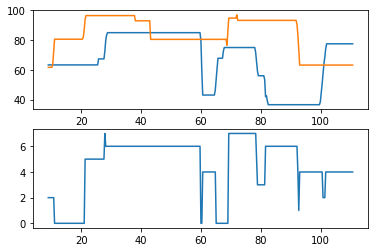

In [153]:
sclust = SpectralClustering(n_clusters=8)

mint = 30
maxt=370

X = np.stack([focus_q[mint:maxt,1],subt_q[mint:maxt,1]]).T
S = manhattan_distances(X)

sclust.fit(X)

plt.subplot(2,1,1)
plt.plot(focus_q[mint:maxt,0],focus_q[mint:maxt,1])
plt.plot(subt_q[mint:maxt,0],subt_q[mint:maxt,1])
plt.subplot(2,1,2)
plt.plot(subt_q[mint:maxt,0],sclust.labels_)


KMEANS
--

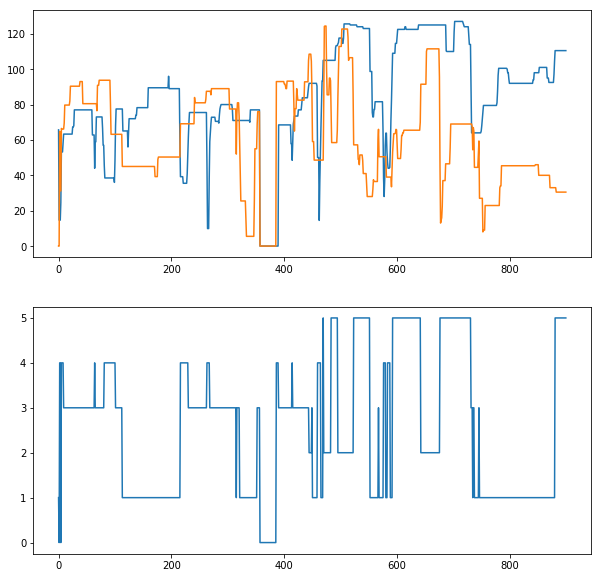

In [194]:
from sklearn.cluster import KMeans
mykmeans = KMeans(n_clusters=6)


mint = 0
maxt=900

X = np.stack([focus_q[mint:maxt,1],subt_q[mint:maxt,1]]).T

mykmeans.fit(X)

subjectivementalstates = mykmeans.labels_

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(focus_q[mint:maxt,0],focus_q[mint:maxt,1])
plt.plot(subt_q[mint:maxt,0],subt_q[mint:maxt,1])
plt.subplot(2,1,2)
plt.plot(subt_q[mint:maxt,0],subjectivementalstates)


In [ ]:
plt.line([])

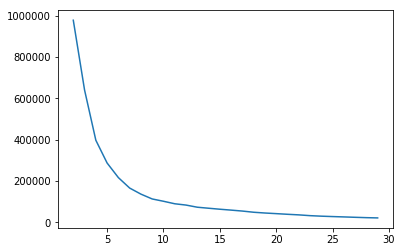

In [187]:
from sklearn.metrics import silhouette_score
inertia = []
sil = []


mint = 0
maxt=900
    
for nclust in range(2,30):
    mykmeans = KMeans(n_clusters=nclust)


    X = np.stack([focus_q[mint:maxt,1],subt_q[mint:maxt,1]]).T

    mykmeans.fit(X)

    sil.append(silhouette_score(X,mykmeans.labels_))
    inertia.append((mykmeans.inertia_))
    
    
plt.plot(range(2,30),inertia)

In [200]:
import librosa

import os 

from tqdm import tqdm

def write_clustered_segments(inputfile,labels_pred,seglength,analysis_name,resultpath,max_n_examples=None,shuffle_examples=True,concat_summary=True,save_indiv=False):

    for i in range(labels_pred.max()+1): # Loop through all cluster labels
        
        if save_indiv:
            # Create a directory for the current label
            os.makedirs(os.path.join(resultpath,'%s/clusters_%d' % (analysis_name,i)),exist_ok=True)

        # fetch all labels with the current value 

        ind_curlabel = np.argwhere(labels_pred==i)

        # Calculate the offsets in the original wave file 
        offsets_wave = ind_curlabel * seglength
        
        if shuffle_examples:
            offsets_wave = np.random.permutation(offsets_wave)

        if max_n_examples is None: 
            curmax_nexamples = len(offsets_wave)
        else:
            curmax_nexamples = max_n_examples

        print("Writing %d examples for Cluster %d" % (curmax_nexamples,i))
        # loop on all examples (maximum of n_examples)
        
        if concat_summary:
            bigwave = []
        
        
        for curoffset in tqdm(range(min(len(offsets_wave),curmax_nexamples))):

            string_offset = '%0.2f_sec_' % offsets_wave[curoffset]

            # cut the original wave file and save the excerpt
            curwave,cursr = librosa.load(path=inputfile, sr = None, mono = False, offset=offsets_wave[curoffset],duration=seglength)
            
            if len(curwave) == 0:
                continue
            
            debug = False
            if debug:
                print(curwave.shape)
                print(cursr)
                print(os.path.join(resultpath,'%s/clusters_%d/%s.wav' % (analysis_name,i,string_offset)))
            
            if save_indiv:
                librosa.output.write_wav(path=os.path.join(resultpath,'%s/clusters_%d/%s.wav' % (analysis_name,i,string_offset)),y=curwave,sr=cursr)
            if concat_summary:
                bigwave.append(curwave)
    
        if concat_summary:
            bigwave = np.hstack(bigwave)
            librosa.output.write_wav(path=os.path.join(resultpath,'%s/summary_cluster_%d.wav' % (analysis_name,i)),y=bigwave,sr=cursr)
    

In [204]:
inputfile = 'caroleeg_sess2.wav'
labels_pred = subjectivementalstates
seglength = 1 
analysis_name = 'subjective_2'
resultpath = 'results_subjective'

write_clustered_segments(inputfile,labels_pred,seglength,analysis_name,resultpath,max_n_examples=20,shuffle_examples=False,concat_summary=True,save_indiv=True)




  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 0


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 1


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 2


 20%|██        | 4/20 [00:00<00:00, 34.84it/s]

Writing 20 examples for Cluster 3


 35%|███▌      | 7/20 [00:00<00:00, 35.70it/s]

Writing 20 examples for Cluster 4


  0%|          | 0/20 [00:00<?, ?it/s]

Writing 20 examples for Cluster 5


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
